In [1]:
from tqdm import tqdm_notebook as tqdm

In [50]:
# Load ACL Antology
from tqdm import tqdm_notebook as tqdm
import pandas as pd

df = pd.read_excel('ACL_publications.xlsx')
df.keys()

Index(['abstract', 'address', 'author', 'booktitle', 'doi', 'editor',
       'journal', 'month', 'note', 'number', 'pages', 'publisher', 'title',
       'url', 'volume', 'year'],
      dtype='object')

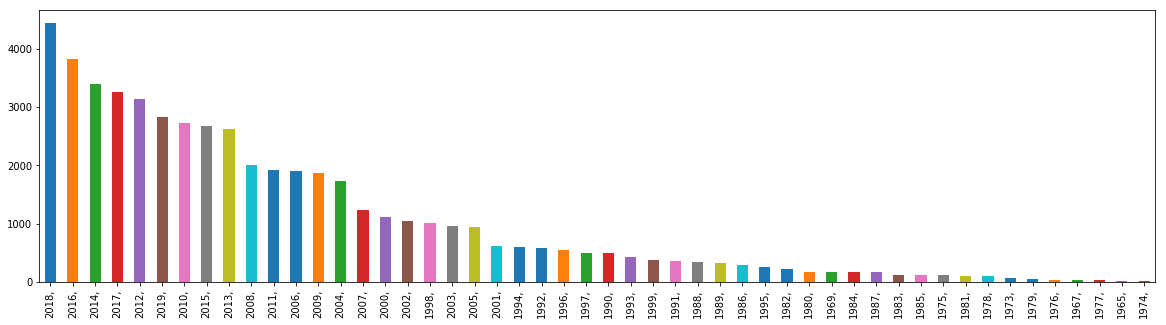

In [53]:
# Paper counts over years
df['year'].value_counts().plot(kind='bar', figsize=(20,5))

In [54]:
# Fix year attribute, remove ',' at the end
df['year'] = df['year'].apply(lambda x: x[:-1])

In [55]:
df = df[df['publisher'].str.contains('Association for Computational Linguistics,', regex=False, na=False)]

In [56]:
# Extract keywords from abstracts

import spacy
from langdetect import detect
from langdetect.lang_detect_exception import LangDetectException

nlp = spacy.load("en_core_web_sm")

In [76]:
key_phrase_counts_over_years  = {
    'overall': {},
    **{year: {} for year in range(1965, 2020)}
}

for i, row in tqdm(df.iterrows(), total=len(df)):
    
    title = row['title']
    year = int(row['year'])
                   
    if isinstance(title, str) and len(title) > 0:
        try:
            # lang = detect(title)
            # if lang == 'en':
            doc = nlp(title)
            for np in doc.noun_chunks:
                if len(np.lemma_.split()) > 1:
                    key_phrase = np.lemma_
                    
                    if all(token.is_stop != True and token.is_punct != True and '-PRON-' not in token.lemma_ 
                           for token in np) == True:    
                        
                        key = np.lemma_.title()
                        
                        if key not in key_phrase_counts_over_years[year]:
                            key_phrase_counts_over_years[year][key] = 1
                        else:
                            key_phrase_counts_over_years[year][key] += 1

                        if key not in key_phrase_counts_over_years['overall']:
                            key_phrase_counts_over_years['overall'][key] = 1
                        else:
                            key_phrase_counts_over_years['overall'][key] += 1
                            
                        
        except LangDetectException as e:
            continue

In [77]:

# filter out common phrases like 'Shared Task:', 'Natural Language Processing' and dataset names 
stop_phrases = {
    'task', 'natural language processing', 'computational linguistics', 'challenge', 'book reviews',
    'the web', 'social media', 'corpus', 'semeval', 'workshop', 'journal'
}

def is_allowed(txt, d):
    tokens = txt.lower().split()
    for i in range(len(tokens)):
        for j in range(i+1, len(tokens)+1):
            if ' '.join(tokens[i:j]) in stop_phrases:
                return False
            
    for np, _ in d.items():
        lower_np = np.lower()
        if txt in lower_np and lower_np != txt:
            return False
    
    return True

overall_key_phrase_counts = key_phrase_counts_over_years['overall']
vocab = {}
for np, count in overall_key_phrase_counts.items():
    if count > 20 and np not in vocab and is_allowed(np, overall_key_phrase_counts):
        vocab[np] = len(vocab)


key_phrase_counts_over_years_filtered = {}        
for year in range(1965, 2020):
    key_phrase_counts_over_years_filtered[year] = {k:v for k, v in key_phrase_counts_over_years[year].items() if k in vocab}

In [144]:
import numpy

data = numpy.zeros((len(vocab), len(key_phrase_counts_over_years_filtered)))

for i, year in enumerate(range(1965, 2020)):
    for np, ix in vocab.items():
        if np in key_phrase_counts_over_years_filtered[year]:
            data[ix, i] = key_phrase_counts_over_years_filtered[year][np]


In [158]:
del vocab['Natural Language']

In [198]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
data_normalized = scaler.fit_transform(data)
data_normalized.shape

(94, 55)

In [199]:
data_normalized[data_normalized == 0.0] = numpy.nan
data_normalized += 1
data_normalized /= 2
data_normalized *= 100


In [200]:
trends = []

for np, np_ix in vocab.items():
    record = {'word': np}
    for i, year in enumerate(range(1965, 2020)):
        record[year] = data_normalized[np_ix, i]
    trends.append(record)
    
trends_df = pd.DataFrame(trends)
trends_df.head()
        

,word,1965,1966,1967,1968,1969,1970,1971,1972,1973,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,Comparable Corpora,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,52.173913,72.727273,55.555556,66.129032,58.620690,59.259259,55.263158,55.813953,50.549451,NaN
1,Word Sense Disambiguation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,60.869565,54.545455,51.851852,51.612903,53.448276,59.259259,55.263158,54.651163,51.648352,51.086957
2,Machine Translation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,76.086957,84.090909,77.777778,90.322581,86.206897,79.629630,86.842105,77.906977,60.989011,67.391304
3,Language Models,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,56.818182,55.555556,53.225806,NaN,51.851852,52.631579,52.325581,53.846154,56.521739
4,Spoken Language Understanding,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,52.272727,53.703704,51.612903,51.724138,53.703704,57.894737,51.162791,52.197802,55.434783


In [201]:
trends_df.to_excel('acl_trends.xlsx')